## Import Libraries

In [1]:
# import libary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

## Load dataset

In [2]:
# Dataset path (see #file:data-set)
dataset_path = "data-set"
dataset_dir = pathlib.Path(dataset_path)

In [3]:
# list of sub directory(class)
class_names = []
for x in os.walk(dataset_path):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 4:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)

print(class_names)

[]


In [4]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

In [5]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2


In [6]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )


Found 885 files belonging to 8 classes.
Using 708 files for training.
Using 708 files for training.


In [7]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )


Found 885 files belonging to 8 classes.
Using 177 files for validation.
Using 177 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)


['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


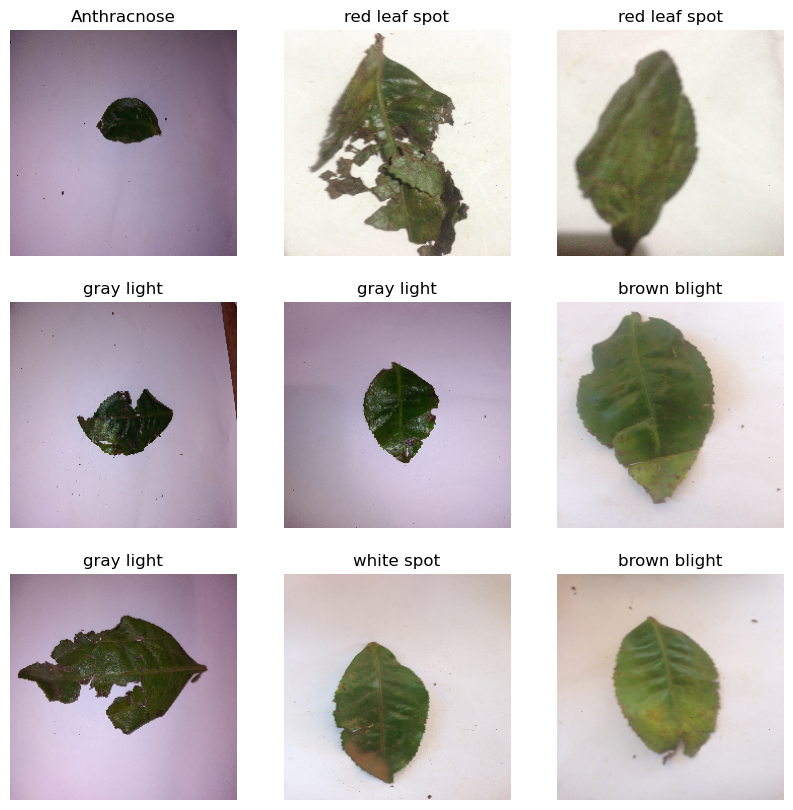

In [9]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Preprocessing

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Build Model

In [11]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

c:\Users\User\anaconda3\envs\torch\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [13]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# display model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 811,832 (3.10 MB)

 Trainable params: 811,704 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

## Train Model

In [15]:
epochs=320
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0
)

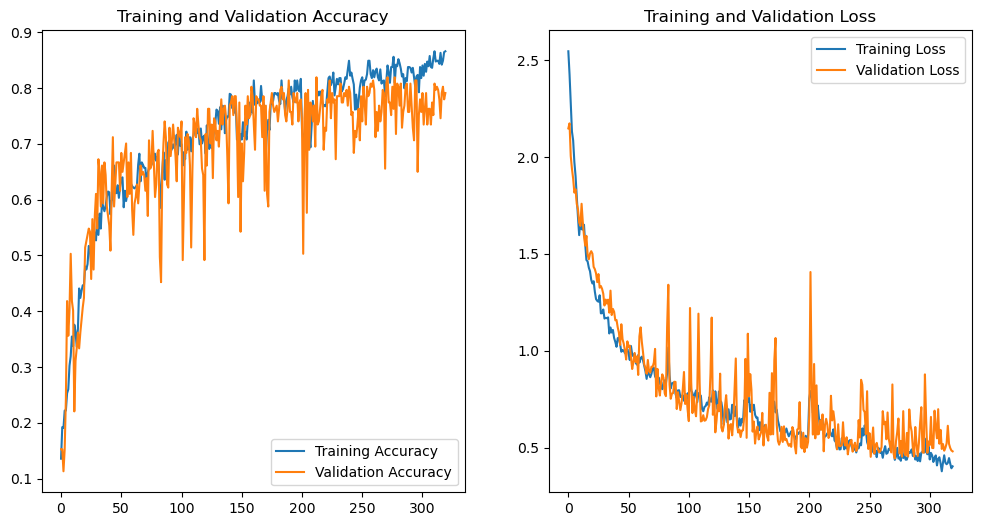

In [16]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate Model

Predictions:
 [4 1 3 7 3 6 3 4 4 1 7 4 6 4 0 6 3 0 6 3 6 4 3 5 7 1 5 5 6 3 4 7 3 4 1 1 4
 4 3 1 5 3 1 7 0 4 7 0 7 0 4 4 2 6 7 1 4 1 6 0 5 3 5 4 3 2 7 6 3 3 7 5 3 3
 3 3 6 3 7 2 7 3 1 7 1 0 0 0 0 1 0 1 5 3 7 1 0 1 2 1 7 5 4 4 3 0 0 7 5 3 1
 3 6 4 6 4 3 4 6 4 3 1 2 7 4 0 4 2]
Labels:
 [0 1 7 7 3 6 3 4 0 1 3 4 6 4 2 6 7 2 6 3 6 0 3 5 7 1 5 5 6 7 2 7 3 4 1 1 4
 4 3 1 5 3 1 3 2 4 7 0 7 0 4 4 4 6 7 1 2 3 6 0 5 3 5 2 3 2 7 6 3 3 7 5 3 7
 3 3 6 7 7 2 7 3 1 7 1 0 0 0 0 1 2 1 5 3 7 7 0 1 2 1 7 5 0 2 3 0 0 7 5 3 1
 3 6 4 6 4 7 4 6 2 3 1 2 7 4 4 0 0]

              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.89      1.00      0.94        16
           2       0.67      0.31      0.42        13
           3       0.77      0.87      0.82        23
           4       0.57      0.87      0.68        15
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        13
           7       0.

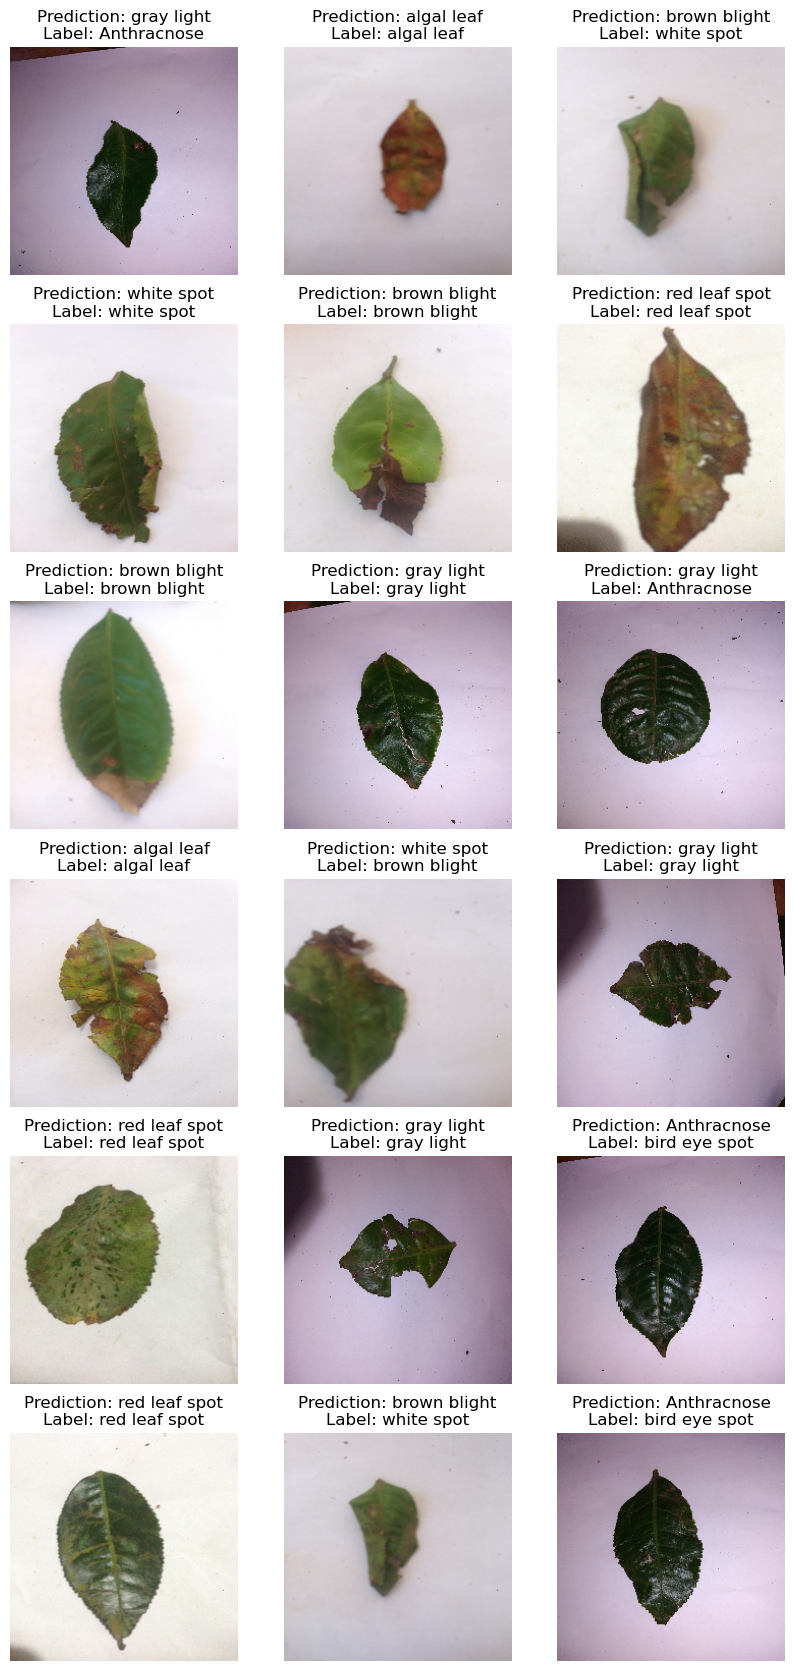

In [17]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

## Save Model History

In [18]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")
history_df.tail()

,accuracy,loss,val_accuracy,val_loss
315,0.862994,0.420695,0.745763,0.612316
316,0.841808,0.445380,0.790960,0.518751
317,0.848870,0.416834,0.802260,0.497431
318,0.864407,0.392765,0.779661,0.484634
319,0.865819,0.402660,0.790960,0.480286


## Save Trained Model

In [19]:
# Save the trained model only
model.save('tea_disease_model_v2.keras')
print("✅ Model saved as 'tea_disease_model_v2.keras'")


✅ Model saved as 'tea_disease_model_v2.keras'


## 📊 Calculate Test Accuracy on Full Validation Set

In [20]:
# Evaluate model on full validation set
print("=" * 60)
print("FINAL EVALUATION")
print("=" * 60)

test_loss, test_accuracy = model.evaluate(val_ds, verbose=1)

print(f"\n📊 Test Accuracy: {test_accuracy*100:.2f}%")
print(f"📊 Test Loss: {test_loss:.4f}")

if test_accuracy >= 0.95:
    print(f"\n🎉 SUCCESS! Target 95-98% achieved!")
elif test_accuracy >= 0.90:
    print(f"\n✅ Good! {test_accuracy*100:.2f}% - Close to target")
else:
    print(f"\n⚠️  Below 90% - Load best_model_final.keras and re-evaluate")

print("=" * 60)


FINAL EVALUATION
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7910 - loss: 0.4803

📊 Test Accuracy: 79.10%
📊 Test Loss: 0.4803

⚠️  Below 90% - Load best_model_final.keras and re-evaluate
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7910 - loss: 0.4803

📊 Test Accuracy: 79.10%
📊 Test Loss: 0.4803

⚠️  Below 90% - Load best_model_final.keras and re-evaluate


In [21]:
# Get detailed classification metrics on entire validation set
all_predictions = []
all_labels = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    all_predictions.extend(np.argmax(predictions, axis=1))
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("\n📋 DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_predictions, target_names=class_names))
print("="*60)



📋 DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

  Anthracnose       0.60      0.60      0.60        25
   algal leaf       0.90      0.95      0.93        20
bird eye spot       0.62      0.29      0.40        17
 brown blight       0.82      0.90      0.86        30
   gray light       0.62      0.84      0.71        25
      healthy       1.00      1.00      1.00        14
red leaf spot       1.00      1.00      1.00        19
   white spot       0.87      0.74      0.80        27

     accuracy                           0.79       177
    macro avg       0.80      0.79      0.79       177
 weighted avg       0.79      0.79      0.78       177



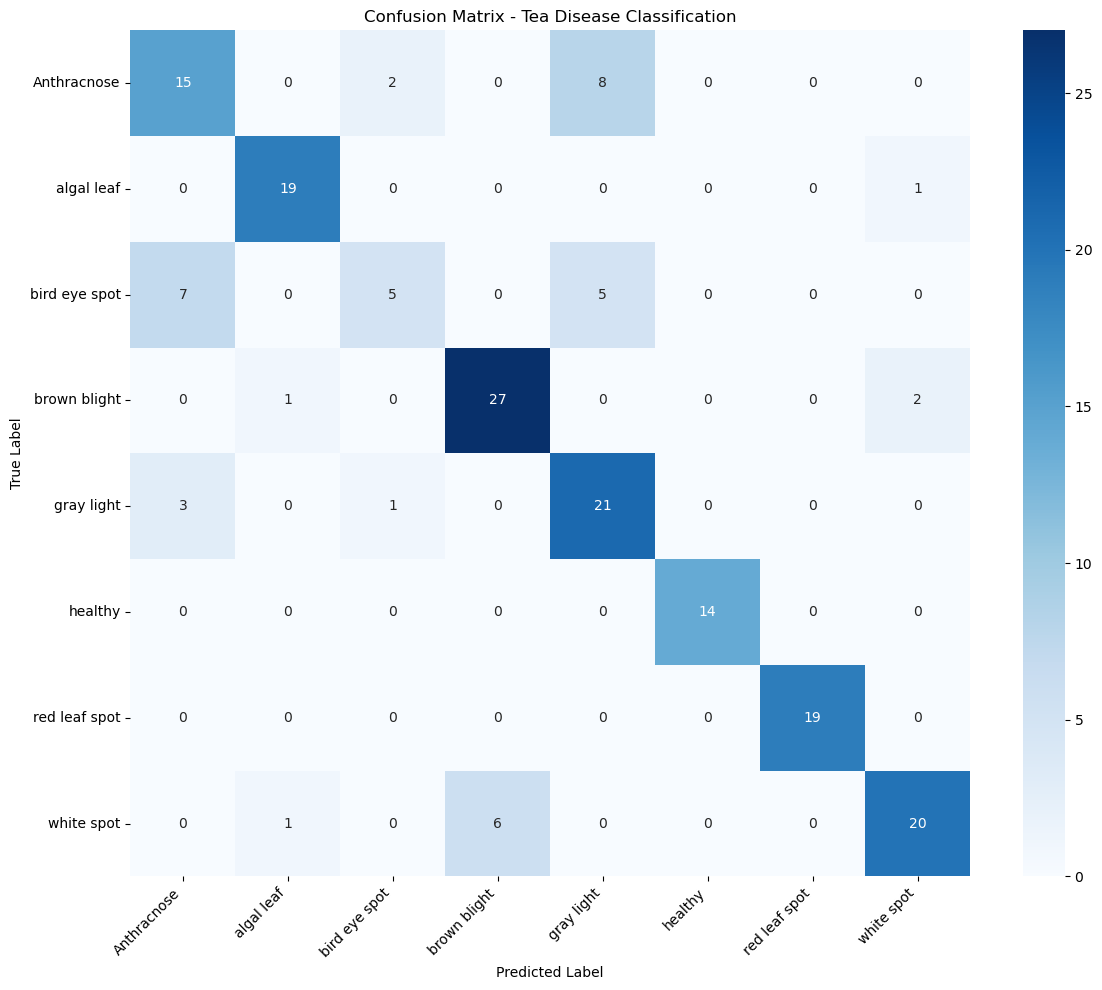

In [22]:
# Optional: Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Tea Disease Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
